### Stock market data analysis

This notebook will focus on data analysis - time series forecasting methods won't be used here, mainly due to the Efficient Market Hypothesis, which states that all (publicly) available information about stocks is already factored into their current prices.

We'll look at:

* The correlation between different assets' returns
* The sharpe ratio of different stocks and ETFs
* The average returns of different assets
* Change in value over time of a portfolio composed of multiple securities

In [2]:
import numpy as np
import pandas as pd

import os

etf_filenames = []
stock_filenames = []

for dirname, _, filenames in os.walk('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/'):
    for filename in filenames:
        etf_filenames.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/'):
    for filename in filenames:
        stock_filenames.append(os.path.join(dirname, filename))

In [3]:
etf_filenames[:5]

['/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/djci.us.txt',
 '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/sqqq.us.txt',
 '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/ipac.us.txt',
 '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/vb.us.txt',
 '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/cper.us.txt']

In [4]:
from collections.abc import Sequence
import os

all_files = etf_filenames.copy()
all_files.extend(stock_filenames)

# Helper function to find files related to specific stocks in this large dataset
def find_files(filename_query: str)->Sequence[str]:
    results = []
    for fn in all_files:
        filename = os.path.basename(fn)
        if filename_query.lower() in filename.lower():
            results.append(fn)
    return results

find_files("voo.us.txt")

['/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/ivoo.us.txt',
 '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/voo.us.txt']

Let's quickly look at the treasury yields data, which we'll need for calculating the Sharpe ratio of different assets.

In [5]:
treasury_yields = pd.read_csv("/kaggle/input/us-treasury-yields-daily/us_treasury_yields_daily.csv", parse_dates=["date"], index_col="date")
treasury_yields = treasury_yields.resample("YS").mean()
treasury_yields.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 1962-01-01 to 2024-01-01
Freq: YS-JAN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   US1M    24 non-null     float64
 1   US3M    44 non-null     float64
 2   US6M    44 non-null     float64
 3   US1Y    63 non-null     float64
 4   US2Y    49 non-null     float64
 5   US3Y    63 non-null     float64
 6   US5Y    63 non-null     float64
 7   US7Y    56 non-null     float64
 8   US10Y   63 non-null     float64
 9   US20Y   57 non-null     float64
 10  US30Y   48 non-null     float64
dtypes: float64(11)
memory usage: 5.9 KB


In [6]:
treasury_yields["US1Y"].head()

date
1962-01-01    3.099960
1963-01-01    3.355984
1964-01-01    3.847080
1965-01-01    4.145743
1966-01-01    5.203640
Freq: YS-JAN, Name: US1Y, dtype: float64

In [7]:
treasury_yields["US1Y"].tail()

date
2020-01-01    0.370120
2021-01-01    0.103984
2022-01-01    2.796506
2023-01-01    5.081720
2024-01-01    5.016471
Freq: YS-JAN, Name: US1Y, dtype: float64

In [8]:
treasury_yields["US1Y"]["2010-01-01":"2020-01-01"]

date
2010-01-01    0.317649
2011-01-01    0.180880
2012-01-01    0.174840
2013-01-01    0.131160
2014-01-01    0.121120
2015-01-01    0.322709
2016-01-01    0.614320
2017-01-01    1.202880
2018-01-01    2.330843
2019-01-01    2.052040
2020-01-01    0.370120
Freq: YS-JAN, Name: US1Y, dtype: float64

<Axes: xlabel='date'>

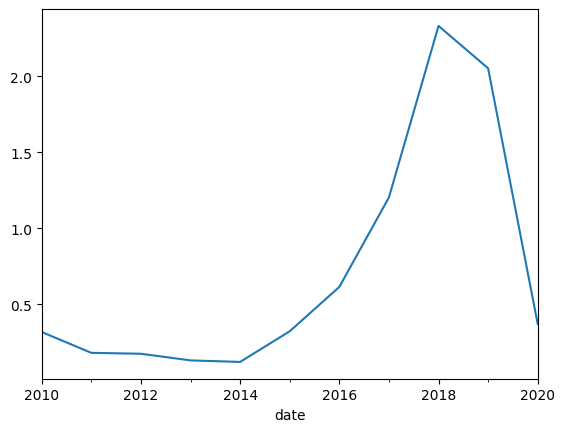

In [9]:
treasury_yields["US1Y"]["2010-01-01":"2020-01-01"].plot()

We can see that the bond yields were quite low between 2010 and 2014 but rose sharply until 2018, dropping again after that.

<Axes: xlabel='date'>

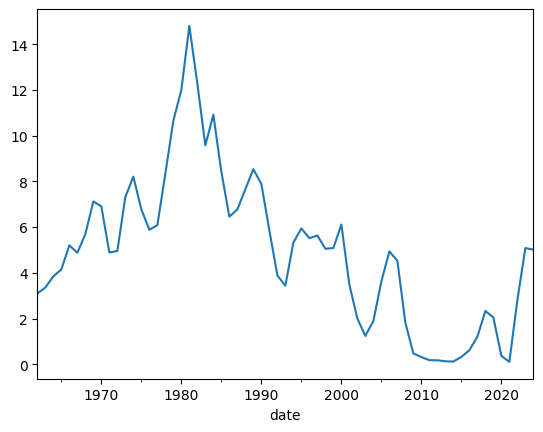

In [10]:
treasury_yields["US1Y"].plot()

The yields varied greatly over the years, with highest values being seen in the early 1980s

In [11]:
find_files("voo")

['/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/voov.us.txt',
 '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/ivoo.us.txt',
 '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/voog.us.txt',
 '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/voo.us.txt']

In [12]:
def load_file(filename: str)->pd.DataFrame:
    return pd.read_csv(filename, parse_dates=["Date"], index_col="Date")

voo = load_file('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/voo.us.txt')
voo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1804 entries, 2010-09-14 to 2017-11-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     1804 non-null   float64
 1   High     1804 non-null   float64
 2   Low      1804 non-null   float64
 3   Close    1804 non-null   float64
 4   Volume   1804 non-null   int64  
 5   OpenInt  1804 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 98.7 KB


### VOO (S&P 500 ETF)

In [13]:
voo.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-09-14,89.832,90.390,89.430,90.006,68023,0
2010-09-15,89.640,90.304,89.447,90.233,10629,0
2010-09-16,89.988,90.251,89.710,90.197,68209,0
2010-09-17,90.740,90.740,89.988,90.286,56797,0
2010-09-20,90.618,91.753,90.374,91.753,21759,0


In [14]:
voo.tail()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2017-11-06,237.24,237.890,237.21,237.79,1688740,0
2017-11-07,237.89,238.220,237.11,237.69,1499080,0
2017-11-08,237.41,238.120,237.15,238.04,4710976,0
2017-11-09,236.73,237.337,235.48,237.18,1644178,0
2017-11-10,236.72,237.180,236.40,237.04,1018957,0


<Axes: xlabel='Date'>

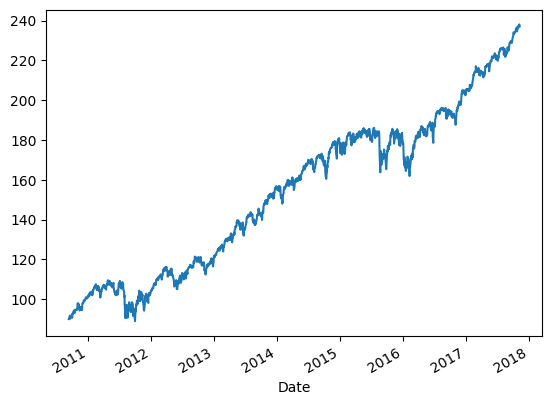

In [15]:
voo["Close"].plot()

We can see that between 2010-09-14 and 2017-11-10 the price of this popular index fund increased from around 90 to 237 USD, which is a ~163% increase.

Let's create a helper function for calculating a stock's returns at a specific frequency (for example monthly or yearly returns), which will be useful for some other indicators of the asset's performance.

In [16]:
def get_stock_returns(stock_df: pd.DataFrame, frequency_string: str, log: bool = False, col: str = "Close")->Sequence[float]:
    """
    Get the sequence of returns of a stock at a given frequency (for example yearly or monthly growth). 
    """
    resampled_prices = stock_df.resample(frequency_string).last()[col]
    resampled_returns = resampled_prices/resampled_prices.shift(1)
    if log:
        resampled_returns = np.log(resampled_returns)
    else:
        resampled_returns = resampled_returns-1
    resampled_returns = resampled_returns.dropna()
    return resampled_returns.to_numpy()

print(get_stock_returns(voo, "MS")) # Monthly returns
print(get_stock_returns(voo, "YS")) # Yearly returns

[ 0.03765658 -0.00099367  0.0641765   0.02237248  0.03452636  0.
  0.02933158 -0.01159923 -0.01681759 -0.02048872 -0.05503742 -0.06807197
  0.10775768 -0.00314744  0.01105081  0.04489119  0.04277575  0.03296014
 -0.00641637 -0.05986561  0.0413998   0.01194402  0.02501541  0.02586577
 -0.01968504  0.00546868  0.00645874  0.05192941  0.01316423  0.03628585
  0.02079511  0.02336729 -0.01500293  0.0527528  -0.03070083  0.03378477
  0.04479504  0.02993124  0.02650871 -0.03538864  0.0458091   0.00872258
  0.00733129  0.02289127  0.02085867 -0.01382022  0.03992751 -0.01394052
  0.02415174  0.02749339 -0.0031348  -0.02880728  0.05591211 -0.01566094
  0.01001335  0.01250275 -0.01947451  0.02174757 -0.06146495 -0.02452994
  0.08451456  0.00426556 -0.01737094 -0.04915489 -0.00209815  0.06862516
  0.00382576  0.017477    0.00315711  0.03680589  0.00097752  0.00051398
 -0.0179287   0.03724434  0.02072722  0.01778656  0.03883495  0.00126168
  0.01040743  0.01404157  0.00628587  0.02064096  0.0029270

We can use the returns to calculate the correlation of two assets, which is a useful metric when creating a robust, diversified portfolio.

### Stock return correlation

In [17]:
def get_aligned_stock_dfs(stock_df1: pd.DataFrame, stock_df2: pd.DataFrame)->tuple[pd.DataFrame, pd.DataFrame]:
    """
    Align two pandas dataframes with a datetime index to their overlapping time period.
    """
    df1_start = stock_df1.index[0]
    df2_start = stock_df2.index[0]

    df1_end = stock_df1.index[-1]
    df2_end = stock_df2.index[-1]

    if df1_start < df2_start:
        start = df2_start
    else:
        start = df1_start

    if df1_end < df2_end:
        end = df1_end
    else:
        end = df2_end

    return (stock_df1[start:end], stock_df2[start:end])

def get_stock_correlation(stock_df1: pd.DataFrame, stock_df2: pd.DataFrame, frequency_string: str = "MS", log: bool = False)->float:
    """
    Get the correlation between two asset's returns.
    """
    aligned_df1, aligned_df2 = get_aligned_stock_dfs(stock_df1, stock_df2)
    returns1 = get_stock_returns(aligned_df1, frequency_string, log)
    returns2 = get_stock_returns(aligned_df2, frequency_string, log)
    return np.corrcoef(returns1, returns2)[0][1]

gold = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/gld.us.txt")
silver = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/slv.us.txt")

print(get_stock_correlation(gold, silver))
print(get_stock_correlation(voo, gold))

0.8123240648513738
0.06682444202507701


We can see that the correlation coefficient between gold and silver (ETFs) is very high - 81%. 

Meanwhile, the correlation of gold with VOO is very low - just 6%. This is not surprising since they're completely different asset classes (stocks of large US companies vs precious metals) and gold is considered a safe haven asset - one in which people invest especially when times are uncertain.



In [18]:
veu = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/veu.us.txt") # All-world ex-us
vti = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/vti.us.txt") # Total US stock market
vt = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/vt.us.txt") # Total world
vwo = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/vwo.us.txt") # Emerging markets

In [19]:
get_stock_correlation(vt, voo)

np.float64(0.9483895007965968)

Vanguard's total world ETF has a high correlation with the S&P500 ETF.

In [20]:
get_stock_correlation(veu, vt)

np.float64(0.981747759793566)

All-world ex-us is (obviously) very highly correlated with the all-world ETF.

In [21]:
get_stock_correlation(vwo, vt)

np.float64(0.9077949492236616)

There's a lower correlation between the emerging markets ETF and the all-world one.

In [22]:
get_stock_correlation(vti, voo)

np.float64(0.9951675344844695)

The largest companies dominate in both VOO and VTI indices so they have an extremely high correlation of over 99%.

Let's plot prices over time of the different ETFs

In [23]:
df_merged = pd.merge(voo["Close"].rename("S&P 500"), veu["Close"].rename("All-world ex-us"), how="inner", left_index=True, right_index=True)
df_merged = pd.merge(df_merged, vti["Close"].rename("Total US"), how="inner", left_index=True, right_index=True)
df_merged = pd.merge(df_merged, vt["Close"].rename("Total World"), how="inner", left_index=True, right_index=True)
df_merged = pd.merge(df_merged, vwo["Close"].rename("Emerging markets"), how="inner", left_index=True, right_index=True)

df_merged

,S&P 500,All-world ex-us,Total US,Total World,Emerging markets
Date,,,,,
2010-09-14,90.006,36.629,50.685,37.897,37.146
2010-09-15,90.233,36.663,50.852,37.931,37.173
2010-09-16,90.197,36.581,50.833,37.834,37.003
2010-09-17,90.286,36.317,50.862,37.731,36.984
2010-09-20,91.753,36.945,51.700,38.310,37.578
...,...,...,...,...,...
2017-11-06,237.790,54.120,133.070,72.700,45.050
2017-11-07,237.690,53.910,132.840,72.550,44.770
2017-11-08,238.040,54.100,133.060,72.710,44.930


<Axes: xlabel='Date'>

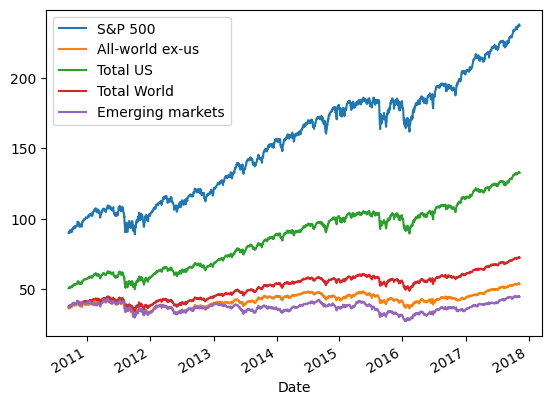

In [24]:
df_merged.plot()

Due to the difference in scale / starting points, it's a bit difficult to say which ETF had the best performance just looking at this graph. We can try graphing a scaled version of the prices.

<Axes: xlabel='Date'>

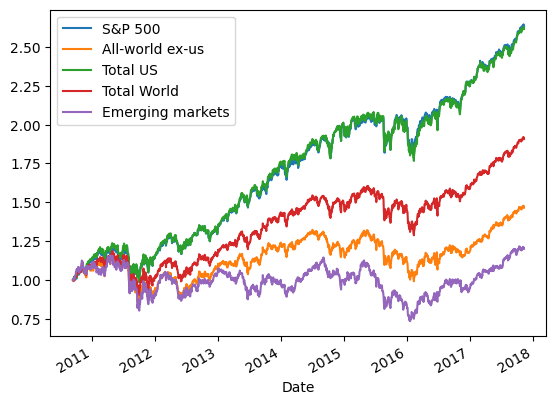

In [25]:
df_merged_scaled = df_merged.copy()
for col in df_merged_scaled.columns:
    df_merged_scaled[col] = df_merged_scaled[col]/ df_merged_scaled[col].iloc[0]

df_merged_scaled.plot()

Now it's much clearer which funds had better performance over this time period. 

Of course, the performance changes over time and the less than 8 year time period depicted here is actually relatively short.

The inception dates of the different ETFs examined above is different, and thus in order to compare them the starting point had to be set to the inception of the newest one, namely VOO, which results in examining them for a shorter time period which does not include the 2008 financial crisis. The inception years of the ETFs are as follows:

VTI 2001  
VT 2008  
VWO 2005  
VOO 2010  
VEU 2007 

To get a larger overview, we can consider the SPDR S&P 500 ETF (SPY), which is the first S&P500 index fund, and compare it to some of the other ETFs. 

Unfortunately, the "all-world" ETFs gained popularity in the 2010s so we won't be able to analyze their performance here on a larger time frame.

In [26]:
spy = load_file('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/spy.us.txt')
spy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3201 entries, 2005-02-25 to 2017-11-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     3201 non-null   float64
 1   High     3201 non-null   float64
 2   Low      3201 non-null   float64
 3   Close    3201 non-null   float64
 4   Volume   3201 non-null   int64  
 5   OpenInt  3201 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 175.1 KB


<Axes: xlabel='Date'>

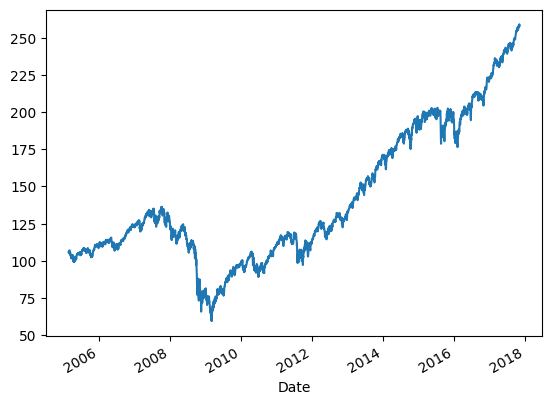

In [27]:
spy["Close"].plot()

In [28]:
def get_stock_sharpe(stock_df):
    """
    Get the sharpe ratio of the given stock (calculated using historical treasury yields and yearly returns data).
    """
    stocks_aligned, treasury_aligned = get_aligned_stock_dfs(stock_df, treasury_yields["US1Y"])
    
    yearly_returns = get_stock_returns(stocks_aligned, "YS")
    bond_yields = treasury_aligned.resample("YS").first()
    bond_yields = bond_yields/100 # The yields are in %
    
    risk_adjusted_returns = yearly_returns - bond_yields
    return np.mean(risk_adjusted_returns)/np.std(risk_adjusted_returns)

get_stock_sharpe(voo)

np.float64(1.3431858968886066)

In [29]:
def get_stock_volatility(stock_df: pd.DataFrame)->float:
    yearly_returns = get_stock_returns(stock_df, "YS")
    return np.std(yearly_returns)

get_stock_volatility(voo)

np.float64(0.09711217824036997)

In [30]:
from scipy.stats import gmean

def calculate_stock_stats(stock_df : pd.DataFrame)->None:
    start_value = stock_df.iloc[0]["Close"]
    end_value = stock_df.iloc[-1]["Close"]
    returns = get_stock_returns(stock_df, "YS")
    avg_return = gmean(returns+1)-1 # Geometric mean instead of arithmetic since this is growth
    
    print(f"Starting value: {start_value}")
    print(f"End value: {end_value}")
    print(f"Average annual growth: {(avg_return*100):.2f} %")
    print(f"Volatility: {get_stock_volatility(stock_df):.2f}")
    print(f"Sharpe ratio: {get_stock_sharpe(stock_df):.2f}")
    
calculate_stock_stats(voo)

Starting value: 90.006
End value: 237.04
Average annual growth: 13.03 %
Volatility: 0.10
Sharpe ratio: 1.34


In [31]:
calculate_stock_stats(vt)

Starting value: 42.839
End value: 72.25
Average annual growth: 10.89 %
Volatility: 0.12
Sharpe ratio: 0.97


In [32]:
calculate_stock_stats(vwo)

Starting value: 21.244
End value: 44.59
Average annual growth: 4.67 %
Volatility: 0.31
Sharpe ratio: 0.28


In [33]:
calculate_stock_stats(spy)

Starting value: 105.79
End value: 258.09
Average annual growth: 7.49 %
Volatility: 0.17
Sharpe ratio: 0.46


We can see that in this data on average VOO and SPY have significantly different annual returns due to the difference in the amount of data available (putting aside the difference related to their Total Expense Ratios).

In [34]:
get_stock_correlation(spy, voo) # Almost 1 due to tracking the same index

np.float64(0.999657629398715)

### Individual stock examination

<Axes: xlabel='Date'>

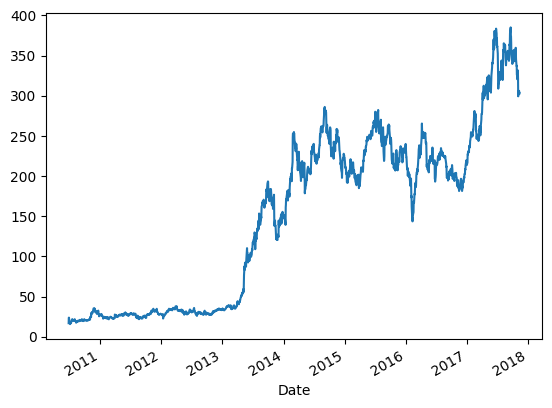

In [35]:
tesla = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/tsla.us.txt")
tesla["Close"].plot()

We can see the rapid rise in Tesla's stock prices after 2013, as well as the volatility of the stock.

In [36]:
calculate_stock_stats(tesla)

Starting value: 17.0
End value: 302.99
Average annual growth: 41.54 %
Volatility: 1.15
Sharpe ratio: 0.56


In [37]:
get_stock_returns(tesla, "YS")

array([ 0.07247465,  0.18592437,  3.44139356,  0.47849498,  0.07913313,
       -0.1096621 ,  0.41789508])

In [38]:
gold = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/gld.us.txt")
calculate_stock_stats(gold)

Starting value: 43.5
End value: 121.13
Average annual growth: 7.37 %
Volatility: 0.16
Sharpe ratio: 0.48


<Axes: xlabel='Date'>

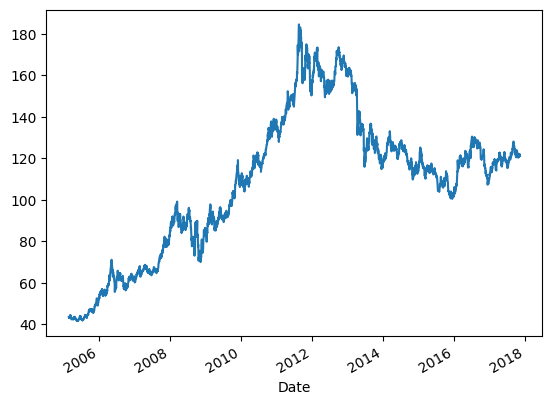

In [39]:
gold["Close"].plot()

<Axes: xlabel='Date'>

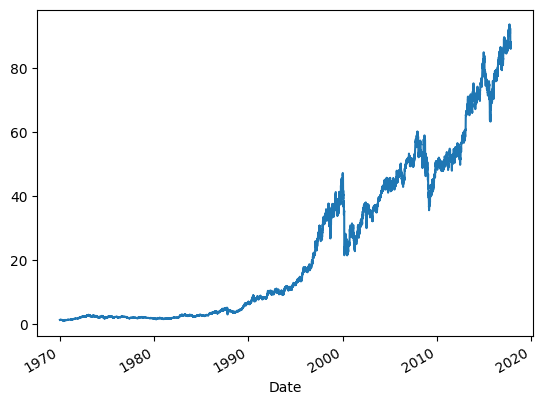

In [40]:
proctor_gamble = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/pg.us.txt")
proctor_gamble["Close"].plot()

Over such a long time period (50 years) the changes in price during the first 25 years are basically invisible because they're dwarfed by the fluctuations later on when the price of the stock was much higher. The period of time until 1990 looks almost like a flat line.

To counter this, we can plot the stock's value using a logarithmic y scale.

<Axes: xlabel='Date'>

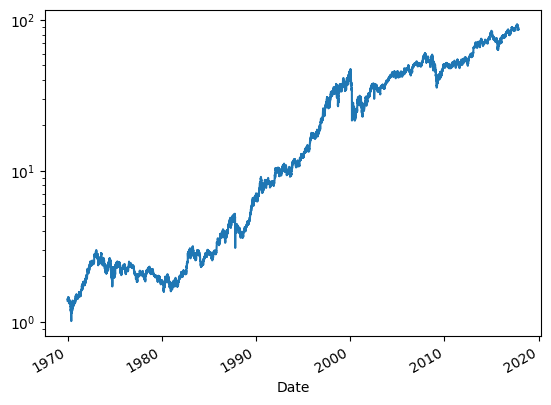

In [41]:
proctor_gamble["Close"].plot(logy=True)

The log scale makes it much easier to see the declining value of the stock between ~1972 and ~1981.

<Axes: xlabel='Date'>

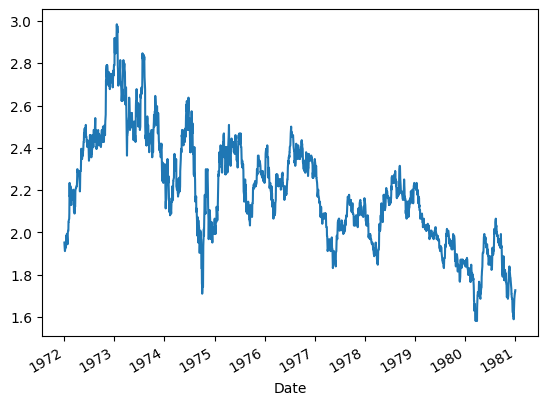

In [105]:
proctor_gamble["Close"]["1972-01-01":"1981-01-01"].plot()

In [42]:
calculate_stock_stats(proctor_gamble)

Starting value: 1.3796
End value: 88.16
Average annual growth: 9.13 %
Volatility: 0.18
Sharpe ratio: 0.29


In [43]:
calculate_stock_stats(proctor_gamble.iloc[-365*10:]) # Last 10 years

Starting value: 36.435
End value: 88.16
Average annual growth: 5.75 %
Volatility: 0.10
Sharpe ratio: 0.49


In [44]:
merck = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/mrk.us.txt")
calculate_stock_stats(merck)

Starting value: 0.5895
End value: 55.48
Average annual growth: 10.38 %
Volatility: 0.28
Sharpe ratio: 0.31


In [45]:
amd = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/amd.us.txt")
nvidia = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/nvda.us.txt")
intel = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/intl.us.txt")
amazon = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/amzn.us.txt")
oracle = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/orcl.us.txt")
netflix = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/nflx.us.txt")
facebook = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/fb.us.txt")

In [46]:
get_stock_correlation(amd, nvidia)

np.float64(0.5185264787356503)

In [47]:
get_stock_correlation(intel, nvidia)

np.float64(0.1763883443385643)

It's interesting that AMD had a much higher correlation with Nvidia in this dataset's time frame than Intel.

<Axes: xlabel='Date'>

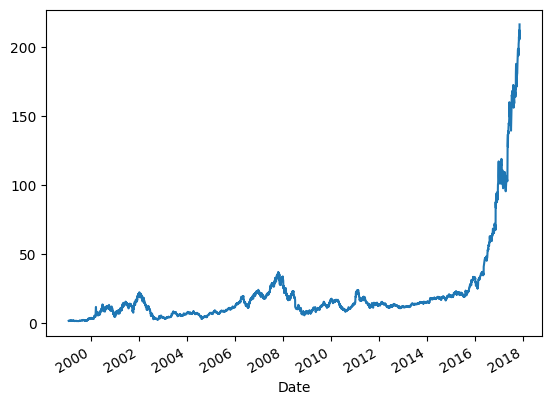

In [48]:
nvidia["Close"].plot()

<Axes: xlabel='Date'>

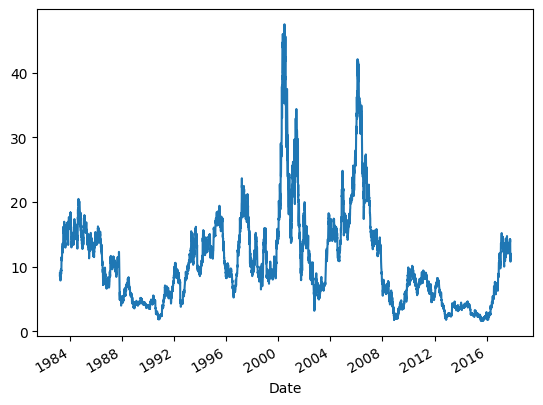

In [49]:
amd["Close"].plot()

<Axes: xlabel='Date'>

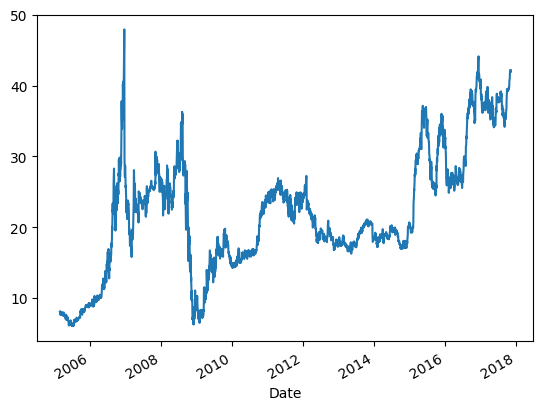

In [50]:
intel["Close"].plot()

In [51]:
get_stock_correlation(amd, intel)

np.float64(0.23121372011092234)

In [52]:
get_stock_correlation(oracle, amazon)

np.float64(0.264612176473004)

In [53]:
get_stock_correlation(facebook, netflix)

np.float64(0.23243521977419507)

<Axes: xlabel='Date'>

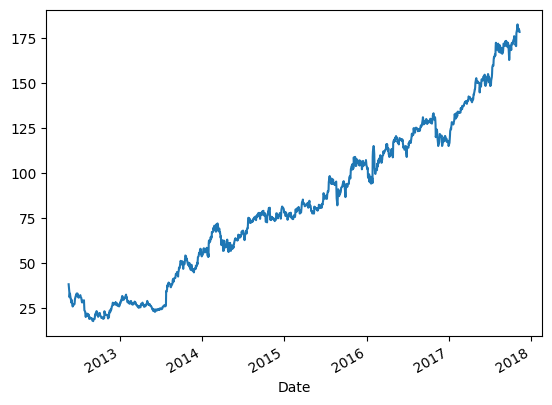

In [54]:
facebook["Close"].plot()

<Axes: xlabel='Date'>

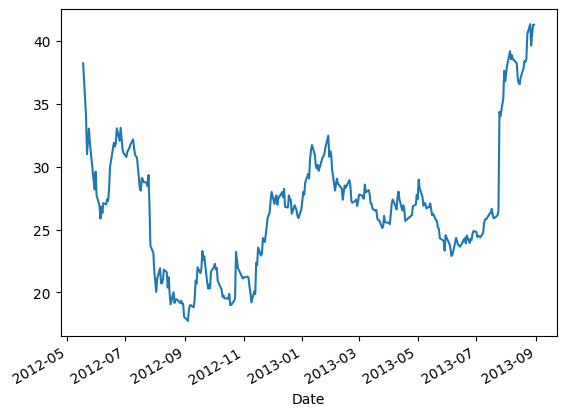

In [55]:
facebook["Close"][:"2013-09-01"].plot()

We can see the initial drop in price of Facebook's shares following its IPO, and how it over a year for the IPO price to recover.

In [56]:
berkshire_hathaway = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/brk-b.us.txt")
taiwan_semiconductor = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/tsm.us.txt")
jpmorgan = load_file("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/jpm.us.txt")

In [57]:
calculate_stock_stats(berkshire_hathaway)

Starting value: 23.2
End value: 183.68
Average annual growth: 10.58 %
Volatility: 0.20
Sharpe ratio: 0.52


In [58]:
calculate_stock_stats(taiwan_semiconductor)

Starting value: 7.1695
End value: 41.72
Average annual growth: 14.86 %
Volatility: 0.21
Sharpe ratio: 0.73


<Axes: xlabel='Date'>

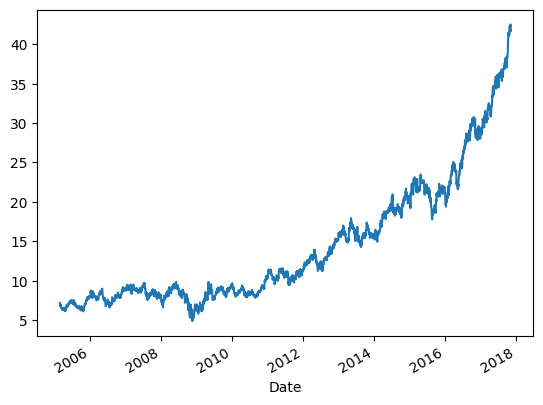

In [59]:
taiwan_semiconductor["Close"].plot()

In [60]:
calculate_stock_stats(jpmorgan)

Starting value: 3.1254
End value: 97.51
Average annual growth: 7.40 %
Volatility: 0.33
Sharpe ratio: 0.21


In [61]:
calculate_stock_stats(netflix)

Starting value: 1.57
End value: 192.02
Average annual growth: 38.47 %
Volatility: 1.00
Sharpe ratio: 0.63


<Axes: xlabel='Date'>

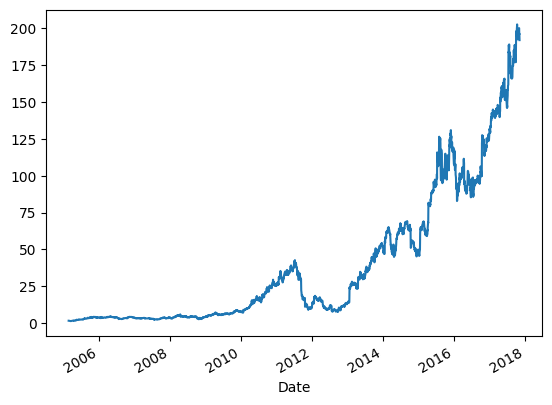

In [62]:
netflix["Close"].plot()

### Portfolio performance calculation

We can check how the value of a portfolio that contains a given number of different stocks would evolve over time by using a weighted average of the prices of the stocks (where the weights are the number of shares owned).

Later we'll also consider the possiblility of buying the shares at different times.

In [78]:
def get_portfolio_df(stocks: Sequence[pd.DataFrame], weights: Sequence[float])-> pd.DataFrame:
    """
    stocks - sequence of dataframes of each stock
    weights - sequence of weights corresponding to the stocks
    """
    processed_stocks = [stock.copy() for stock in stocks]
    for i, stock in enumerate(processed_stocks):
        for col in stock.columns:
            stock[col] = stock[col]*weights[i]
    merged_df = processed_stocks[0]
    for i in range(1, len(processed_stocks)):
        merged_df = merged_df.add(processed_stocks[i], fill_value=0)
    return merged_df

get_portfolio_df([netflix, tesla, gold], [0.25, 0.4, 0.35])

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,29.994008,30.097895,29.862867,30.061781,4.898788e+06,0.0
2005-02-28,30.187075,30.228629,30.065657,30.069679,1.449944e+06,0.0
2005-03-01,29.918759,29.971800,29.779745,29.865679,2.852459e+06,0.0
2005-03-02,29.824730,29.960091,29.765828,29.884052,2.848321e+06,0.0
2005-03-03,29.753908,29.805950,29.640337,29.689567,2.354415e+06,0.0
...,...,...,...,...,...,...
2017-11-06,287.770920,289.182850,282.872646,285.996461,9.325247e+06,0.0
2017-11-07,284.621420,287.887660,283.169010,286.981891,6.810478e+06,0.0
2017-11-08,287.188200,288.347921,284.344853,286.345115,7.134295e+06,0.0


<Axes: xlabel='Date'>

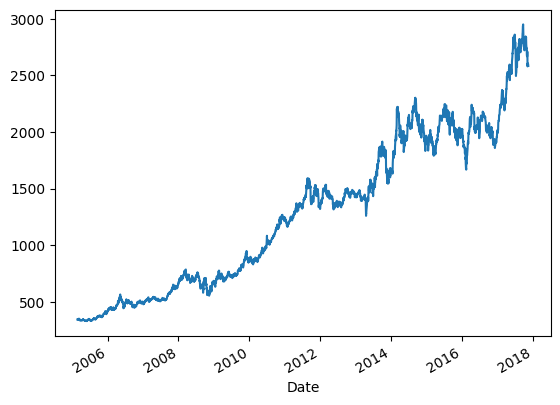

In [85]:
get_portfolio_df([netflix, tesla, gold], [3, 3, 4])["Close"].plot()

<Axes: xlabel='Date'>

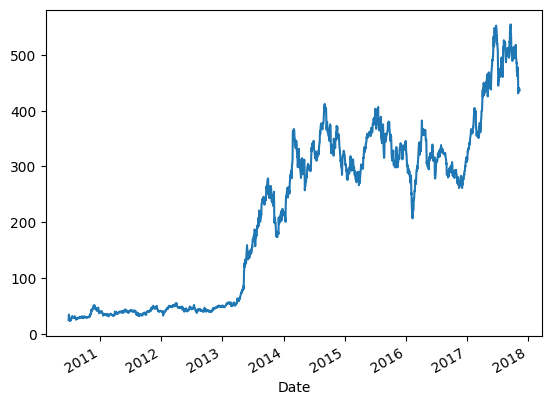

In [80]:
tesla["Close"].plot()

<Axes: xlabel='Date'>

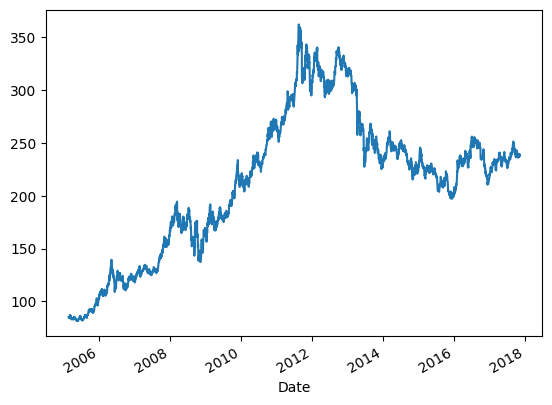

In [81]:
gold["Close"].plot()

<Axes: xlabel='Date'>

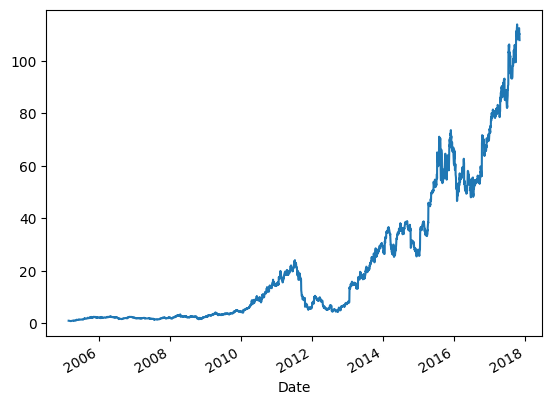

In [82]:
netflix["Close"].plot()

For a more complex example, we can also consider the possibility of buying shares at different times:

In [86]:
from dataclasses import dataclass

@dataclass
class StockPurchase:
    purchase_time: str # e.g. "2012-01-01"
    stock_df: pd.DataFrame
    shares_purchased: int

purchase_netflix = StockPurchase("2015-01-01", netflix, 5)
purchase_tesla = StockPurchase("2013-01-01", tesla, 2)
purchase_gold = StockPurchase("2015-01-01", gold, 4)

def get_portfolio_value_ts(stocks: Sequence[StockPurchase]):
    processed_stock_dfs = [stock.stock_df[stock.purchase_time:] for stock in stocks]
    weights = [stock.shares_purchased for stock in stocks]
    return get_portfolio_df(processed_stock_dfs, weights)

get_portfolio_value_ts([purchase_netflix, purchase_tesla, purchase_gold])

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2013-01-02,100.051200,102.096000,99.950400,101.836800,3.440765e+06,0.0
2013-01-03,101.318400,102.096000,100.080000,100.137600,2.136790e+06,0.0
2013-01-04,100.224000,100.224000,97.689600,99.072000,1.941100e+06,0.0
2013-01-07,99.676800,100.224000,97.632000,98.899200,1.272698e+06,0.0
2013-01-08,99.360000,99.360000,95.356800,96.998400,3.697877e+06,0.0
...,...,...,...,...,...,...
2017-11-06,2393.104800,2410.379000,2364.408125,2388.608025,8.961623e+07,0.0
2017-11-07,2379.253600,2396.290400,2360.052600,2382.651025,6.604945e+07,0.0
2017-11-08,2387.178000,2396.598825,2368.715850,2382.479500,6.913992e+07,0.0


<Axes: xlabel='Date'>

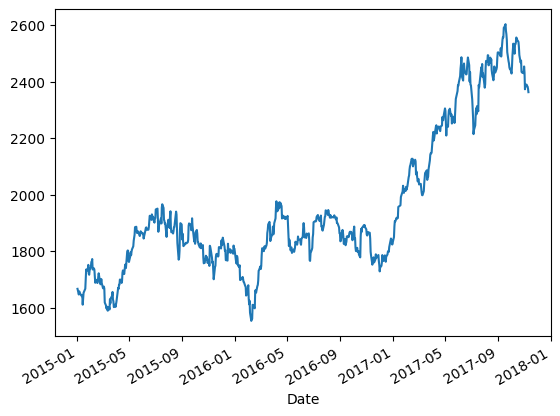

In [95]:
purchase_netflix = StockPurchase("2015-01-01", netflix, 5)
purchase_tesla = StockPurchase("2015-01-01", tesla, 2)
purchase_gold = StockPurchase("2015-01-01", gold, 4)

# All stocks bought at once
get_portfolio_value_ts([purchase_netflix, purchase_tesla, purchase_gold])["Close"].plot()

<Axes: xlabel='Date'>

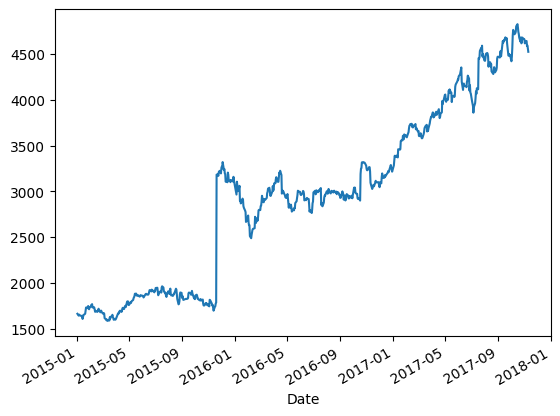

In [96]:
purchase_netflix_1 = StockPurchase("2015-01-01", netflix, 5)
purchase_netflix_2 = StockPurchase("2015-11-20", netflix, 20)
purchase_tesla = StockPurchase("2015-01-01", tesla, 2)
purchase_gold = StockPurchase("2015-01-01", gold, 4)

# An additional purchase of Netflix in November 2015
get_portfolio_value_ts([purchase_netflix_1, purchase_netflix_2, purchase_tesla, purchase_gold])["Close"].plot()

<Axes: xlabel='Date'>

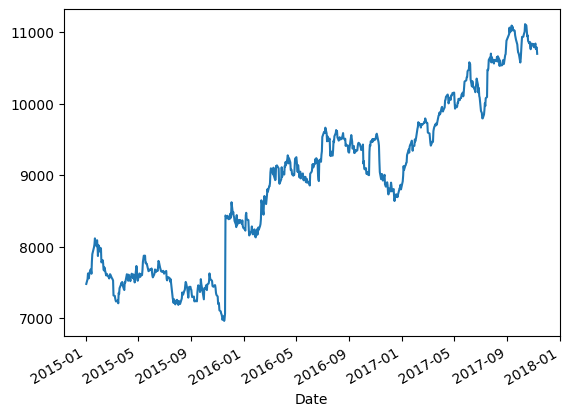

In [100]:
purchase_netflix_1 = StockPurchase("2015-01-01", netflix, 5)
purchase_netflix_2 = StockPurchase("2015-11-20", netflix, 20)
purchase_tesla = StockPurchase("2015-01-01", tesla, 2)
purchase_gold = StockPurchase("2015-01-01", gold, 30)

get_portfolio_value_ts([purchase_netflix_1, purchase_netflix_2, purchase_tesla, purchase_gold])["Close"].plot()

Adding more gold to the portfolio makes the drop in value at the end of 2016 more prominent since it contributes more to the overall portfolio

<Axes: xlabel='Date'>

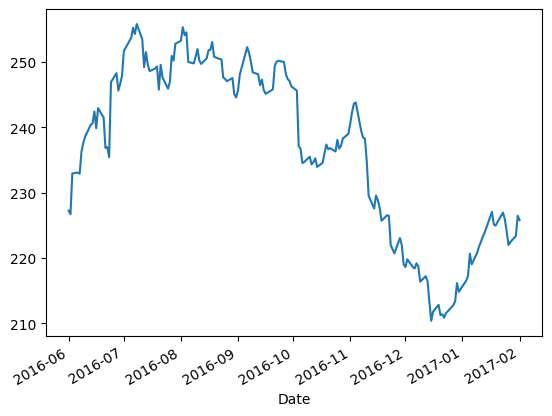

In [103]:
gold["Close"]["2016-06-01":"2017-02-01"].plot()